In [1]:
import math
import random
import time

In [2]:
dough_length = 500

biscuits = {
    0: {"length": 4, "value": 6, "defects": {"a": 4, "b": 2, "c": 3}, "id": 0},
    1: {"length": 8, "value": 12, "defects": {"a": 5, "b": 4, "c": 4}, "id": 1},
    2: {"length": 2, "value": 1, "defects": {"a": 1, "b": 2, "c": 1}, "id": 2},
    3: {"length": 5, "value": 8, "defects": {"a": 2, "b": 3, "c": 2}, "id": 3},
}

MAX_BISCUIT_LENGTH = max(b["length"] for b in biscuits.values())

In [3]:
with open("defects.csv") as f:
    lines = f.readlines()
    defects = [line.strip().split(",") for line in lines[1:]]

# Defects never occur at precise integer coordinates, so a defect will never be shared by two tiles.
# We floor each defect coordinate to get the tile it belongs to.
# We then count the number of defects in each tile.
defect_counts = {}
for x, y in defects:
    x = int(float(x))
    if x not in defect_counts:
        defect_counts[x] = {"a": 0, "b": 0, "c": 0}

    defect_counts[x][y] += 1

for x in range(dough_length):
    if x not in defect_counts:
        defect_counts[x] = {"a": 0, "b": 0, "c": 0}

print(len(defect_counts))

500


In [4]:
class SimulatedAnnealing:
    """
    Simulated Annealing Algorithm for the Biscuit Problem
    """
    
    def __init__(self, state, temperature=1.0, cooling_rate=0.99, min_temperature=0.01):
        self.state = state
        self.temperature = temperature
        self.cooling_rate = cooling_rate
        self.min_temperature = min_temperature
        self.best_state = state
        self.history = []
        self.best_value = 0

    @staticmethod
    def evaluate_state(state):
        """
        Evaluates the value of a state.

        Parameters:
        - state (list): The state to evaluate.

        Returns:
        - value (float): The value of the state.
        """
        return sum(biscuits[biscuit]["value"] for biscuit in state if biscuit != -1)

    @staticmethod
    def apply_change(state, pos, new_biscuit):
        """
        Applies a change to the state and returns the new state if the change is valid, otherwise returns None.
        If biscuits are overlapping with the new biscuit, they are removed.
        
        Parameters:
        - state (list): The current state.
        - pos (int): The position to place the new biscuit.
        - new_biscuit (int): The new biscuit to place.
        
        Returns:
        - new_state (list): The new state if the change is valid, otherwise None.
        """

        state[pos] = new_biscuit

        if new_biscuit == -1:
            return state

        if pos + biscuits[new_biscuit]["length"] - 1 >= dough_length:
            return None

        # Place new biscuit and remove overlapping biscuits
        for i in range(max(pos - MAX_BISCUIT_LENGTH, 0), pos):
            if state[i] != -1 and i + biscuits[state[i]]["length"] - 1 >= pos:
                state[i] = -1
        for i in range(pos + 1, min(pos + biscuits[new_biscuit]["length"], dough_length)):
            state[i] = -1

        biscuit_defects = {"a": 0, "b": 0, "c": 0}

        # Count biscuit defects
        for i in range(pos, pos + biscuits[new_biscuit]["length"]):
            for defect_type in ["a", "b", "c"]:
                biscuit_defects[defect_type] += defect_counts[i][defect_type]
        
        valid = True
        # Compare with threshold
        for defect_type in ["a", "b", "c"]:
            if biscuit_defects[defect_type] > biscuits[new_biscuit]["defects"][defect_type]:
                valid = False
                break
        
        return state if valid else None

    # Simulated Annealing Algorithm
    def run(self, max_time=120):
        """
        Runs the simulated annealing algorithm to optimize the biscuit production.

        Parameters:
        - max_time (int): The maximum time in seconds to run the algorithm. Default is 120 seconds.

        Returns:
        - best_state (list): The best state found by the algorithm.
        - best_value (float): The value of the best state found by the algorithm.
        """
        
        start_time = time.time()
        self.state
        self.value = SimulatedAnnealing.evaluate_state(self.state)
        self.history.append((self.value, self.best_value, self.temperature))
        self.best_state = self.state.copy()
        self.best_value = self.value

        last_print_time = time.time()
        while self.temperature > self.min_temperature and time.time() - start_time < max_time:
            new_state = self.state.copy()

            # Randomly modify the current solution
            pos = random.randint(0, dough_length - 1)
            choice_list = [-1, 0, 1, 2, 3]
            choice_list.remove(self.state[pos])
            new_biscuit = random.choice(choice_list)
            
            # Update state and calculate new value
            new_state = SimulatedAnnealing.apply_change(new_state, pos, new_biscuit)
            if new_state is None:
                continue
            new_value = SimulatedAnnealing.evaluate_state(new_state)

            # Calculate change in value
            value_change = new_value - self.value

            # Decide whether to accept the new solution
            if value_change >= 0 or random.uniform(0, 1) < math.exp(value_change / self.temperature):
                self.value = new_value
                if new_value > self.best_value:
                    self.best_state = new_state.copy()
                    self.best_value = new_value
                self.state = new_state.copy()

            # Decrease the temperature
            self.temperature *= self.cooling_rate
            self.history.append((self.value, self.best_value, self.temperature))

            if time.time() - last_print_time > 1:
                print(f"Iteration {len(self.history)}: value = {self.value}, best_value = {self.best_value}, temperature = {self.temperature}")
                last_print_time = time.time()

        return self.best_state, self.best_value


In [5]:
# Run the algorithm
starting_state = [-1] * dough_length
simulated_annealing = SimulatedAnnealing(starting_state, temperature=1.0, cooling_rate=0.99999, min_temperature=0.01)
best_state, total_value = simulated_annealing.run(max_time=150)
print("Best State:", best_state)
print("Total Value:", total_value)


Iteration 19874: value = 686, best_value = 696, temperature = 0.8197703871094668
Iteration 40589: value = 706, best_value = 708, temperature = 0.6663887770640605
Iteration 62045: value = 704, best_value = 711, temperature = 0.5377061260233846
Iteration 81255: value = 723, best_value = 724, temperature = 0.44372775779687046
Iteration 101234: value = 721, best_value = 724, temperature = 0.36336949797146284
Iteration 121033: value = 723, best_value = 724, temperature = 0.29810006756833063
Iteration 138944: value = 724, best_value = 724, temperature = 0.24921558667123755
Iteration 159081: value = 725, best_value = 725, temperature = 0.20376091575352492
Iteration 177350: value = 725, best_value = 725, temperature = 0.1697380576660332
Iteration 197740: value = 725, best_value = 725, temperature = 0.13842870004812122
Iteration 218013: value = 725, best_value = 725, temperature = 0.11302673439761064
Iteration 239358: value = 725, best_value = 725, temperature = 0.09130205641526881
Iteration 26

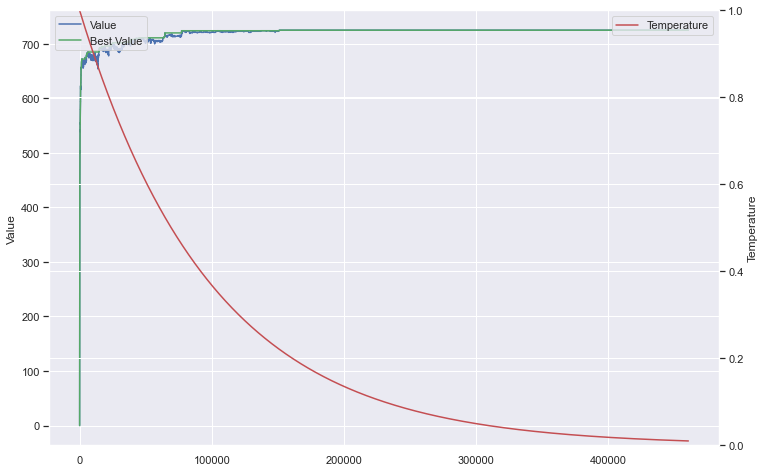

In [9]:
# Plot the value history, along with the temperature and best value
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.figure(figsize=(12, 8))

value_history, best_value_history, temperature_history = zip(*simulated_annealing.history)

# Plotting Value and Best Value on the primary y-axis
ax1 = plt.gca()
ax1.plot(value_history, label="Value", color='b')
ax1.plot(best_value_history, label="Best Value", color='g')
ax1.set_ylabel('Value')

# Creating a secondary y-axis for Temperature
ax2 = plt.gca().twinx()
ax2.plot(temperature_history, label="Temperature", color='r')
ax2.set_ylabel('Temperature')
ax2.set_ylim(0, 1)  # Setting the limit for temperature scale

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig("fitness_history_sa.png", dpi=300)
plt.show()

In [7]:
from utils import check_solution
# Build and check solution
solution = [(x, best_state[x]) for x in range(dough_length) if best_state[x] != -1]
print(check_solution(solution))

(725, [(0, 1), (8, 1), (16, 1), (24, 0), (28, 1), (36, 0), (40, 1), (48, 2), (51, 1), (59, 1), (67, 2), (69, 1), (77, 1), (85, 1), (93, 0), (98, 1), (106, 2), (108, 3), (114, 0), (118, 0), (122, 2), (124, 1), (132, 1), (140, 0), (144, 3), (149, 1), (158, 1), (167, 1), (175, 1), (185, 2), (187, 1), (195, 1), (203, 1), (211, 3), (216, 0), (220, 1), (228, 1), (236, 1), (244, 1), (252, 3), (257, 3), (262, 1), (270, 1), (278, 1), (286, 1), (294, 3), (300, 1), (308, 1), (316, 1), (324, 3), (329, 1), (337, 1), (345, 1), (353, 0), (357, 1), (365, 0), (369, 0), (373, 1), (382, 1), (390, 1), (398, 2), (400, 1), (408, 1), (416, 1), (424, 1), (433, 1), (441, 2), (443, 1), (451, 1), (459, 3), (464, 1), (472, 1), (480, 0), (484, 1), (492, 1)], True)


In [8]:
from utils import save_solution
# Save solution
save_solution(solution, "solution_simulated_annealing.txt")